In [120]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

from tqdm.notebook import tqdm
from joblib import Parallel, delayed

from proglearn.forest import UncertaintyForest, KDEUncertaintyForest

In [121]:
def generate_data(n, d, var):
    means = [np.ones(d) * -1, np.ones(d)]    
    X = np.concatenate([np.random.multivariate_normal(mean, var * np.eye(len(mean)), 
                                                 size=int(n / 2)) for mean in means])

    y = np.concatenate([np.ones(int(n / 2)) * mean_idx for mean_idx in range(len(means))])
    return X, y

In [122]:
def get_reliability(predicted_posterior, y, y_val_of_interest, num_bins = 10):
    hists = []
    hists_hat = []
    amts = []
    for i in range(num_bins):
        prop = i*1./num_bins
        inds = np.where((predicted_posterior[:, y_val_of_interest] >= prop) & (predicted_posterior[:, y_val_of_interest] <= prop+1./num_bins))[0]
        amts.append(len(inds))
        if len(inds) > 0:
            hists.append(len(np.where(y[inds] == y_val_of_interest)[0])*1./len(inds))
            hists_hat.append(np.mean(predicted_posterior[inds, y_val_of_interest]))
        else:
            hists.append(prop)
            hists_hat.append(prop + 0.5/num_bins)
    return np.array(hists), np.array(hists_hat), np.array(amts)

In [123]:
def estimate_reliabilities(algo, n_train, n_test, d, var, num_trials, parallel = False, num_bins = 10):
    obj = algo['instance']
    def worker():
        X_train, y_train = generate_data(n_train, d, var)
        obj.fit(X_train, y_train)
        X_test, y_test = generate_data(n_test, d, var)
        return get_reliability(obj.predict_proba(X_test), y_test, 1, num_bins = num_bins)
        
    if parallel:
        predicted_posterior = np.array(Parallel(n_jobs=-2)(delayed(worker)(t) for t in range(num_trials)))
    else:
        predicted_posterior = np.zeros((num_trials, 3, num_bins))
        for t in tqdm(range(num_trials)):
            predicted_posterior[t] = worker()

    return predicted_posterior

In [151]:
# For either a CART, Honest, or Uncertainty Forest, plot P(Y = 1 | X = x).
def plot_posterior(ax, algo):
    # Plot each of num_plotted_trials iterations, highlighting a single line.
    ax.plot(np.mean(algo['predicted_posterior'][:, 1], axis = 0), 
            np.mean(algo['predicted_posterior'][:, 0], axis = 0), 
            label = algo['label'],
            linewidth = 8 if algo['title'] != "Kernel Density Forest" else 16, 
            color = algo['color'], 
            alpha = 1)
    ECEs = []
    for trial in range(len(algo['predicted_posterior'])):
        ECE = np.dot(
            np.abs(algo['predicted_posterior'][trial, 1] - algo['predicted_posterior'][trial, 0]), 
            algo['predicted_posterior'][trial, 2]) / np.sum(algo['predicted_posterior'][trial, 2])
        ECEs.append(ECE)
    mECE = np.mean(ECEs)
    ax.set_title(algo['title'] + '\nmECE: {:0.4f}'.format(mECE))

In [159]:
# Communal plotting parameters.
def plot_fig1(algos):
    sns.set(font_scale = 6)
    sns.set_style("ticks")
    plt.rcParams['figure.figsize'] = [50, 15]
    fig, axes = plt.subplots(1, len(algos))
    for ax in axes[0:len(algos)]:
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        ax.set_xticks([0.0, 0.5, 1.0])
        ax.set_yticks([0.0, 0.5, 1.0])

    # 3 posterior plots.
    for i in range(len(algos)):
        plot_posterior(axes[i], 
                       algos[i])
    
    fig.text(0.5, 0.0, r"$\hat P(Y = 1|X = x)$", ha='center')
    axes[0].set_ylabel(r"$P(Y = 1|X = x)$")
    
    fig.suptitle("Reliability Diagrams", y=1.06)
    fig.tight_layout()
    plt.show()

In [154]:
# Real Params.
n_train = 50
n_test = 10000
d = 100
var = 0.25
num_trials = 10
n_estimators = 100

# Algorithms.
algos = [
    {
        'instance': KDEUncertaintyForest(n_estimators = n_estimators),
        'label': 'KDF',
        'title': 'Kernel Density Forest',
        'color': "#F41711",
    },
    {
        'instance': UncertaintyForest(n_estimators = n_estimators),
        'label': 'UF',
        'title': 'Uncertainty Forest',
        'color': "#0000ff",
    },
    {
        'instance': RandomForestClassifier(n_estimators = n_estimators),
        'label': 'CART',
        'title': 'CART Forest',
        'color': "#1b9e77",
    }
]

# Plotting parameters.
parallel = False

In [155]:
# Generate data and predictions.
for algo in algos:
    algo['predicted_posterior'] = estimate_reliabilities(algo, n_train, n_test, d, var, num_trials, parallel = parallel, num_bins = 40)

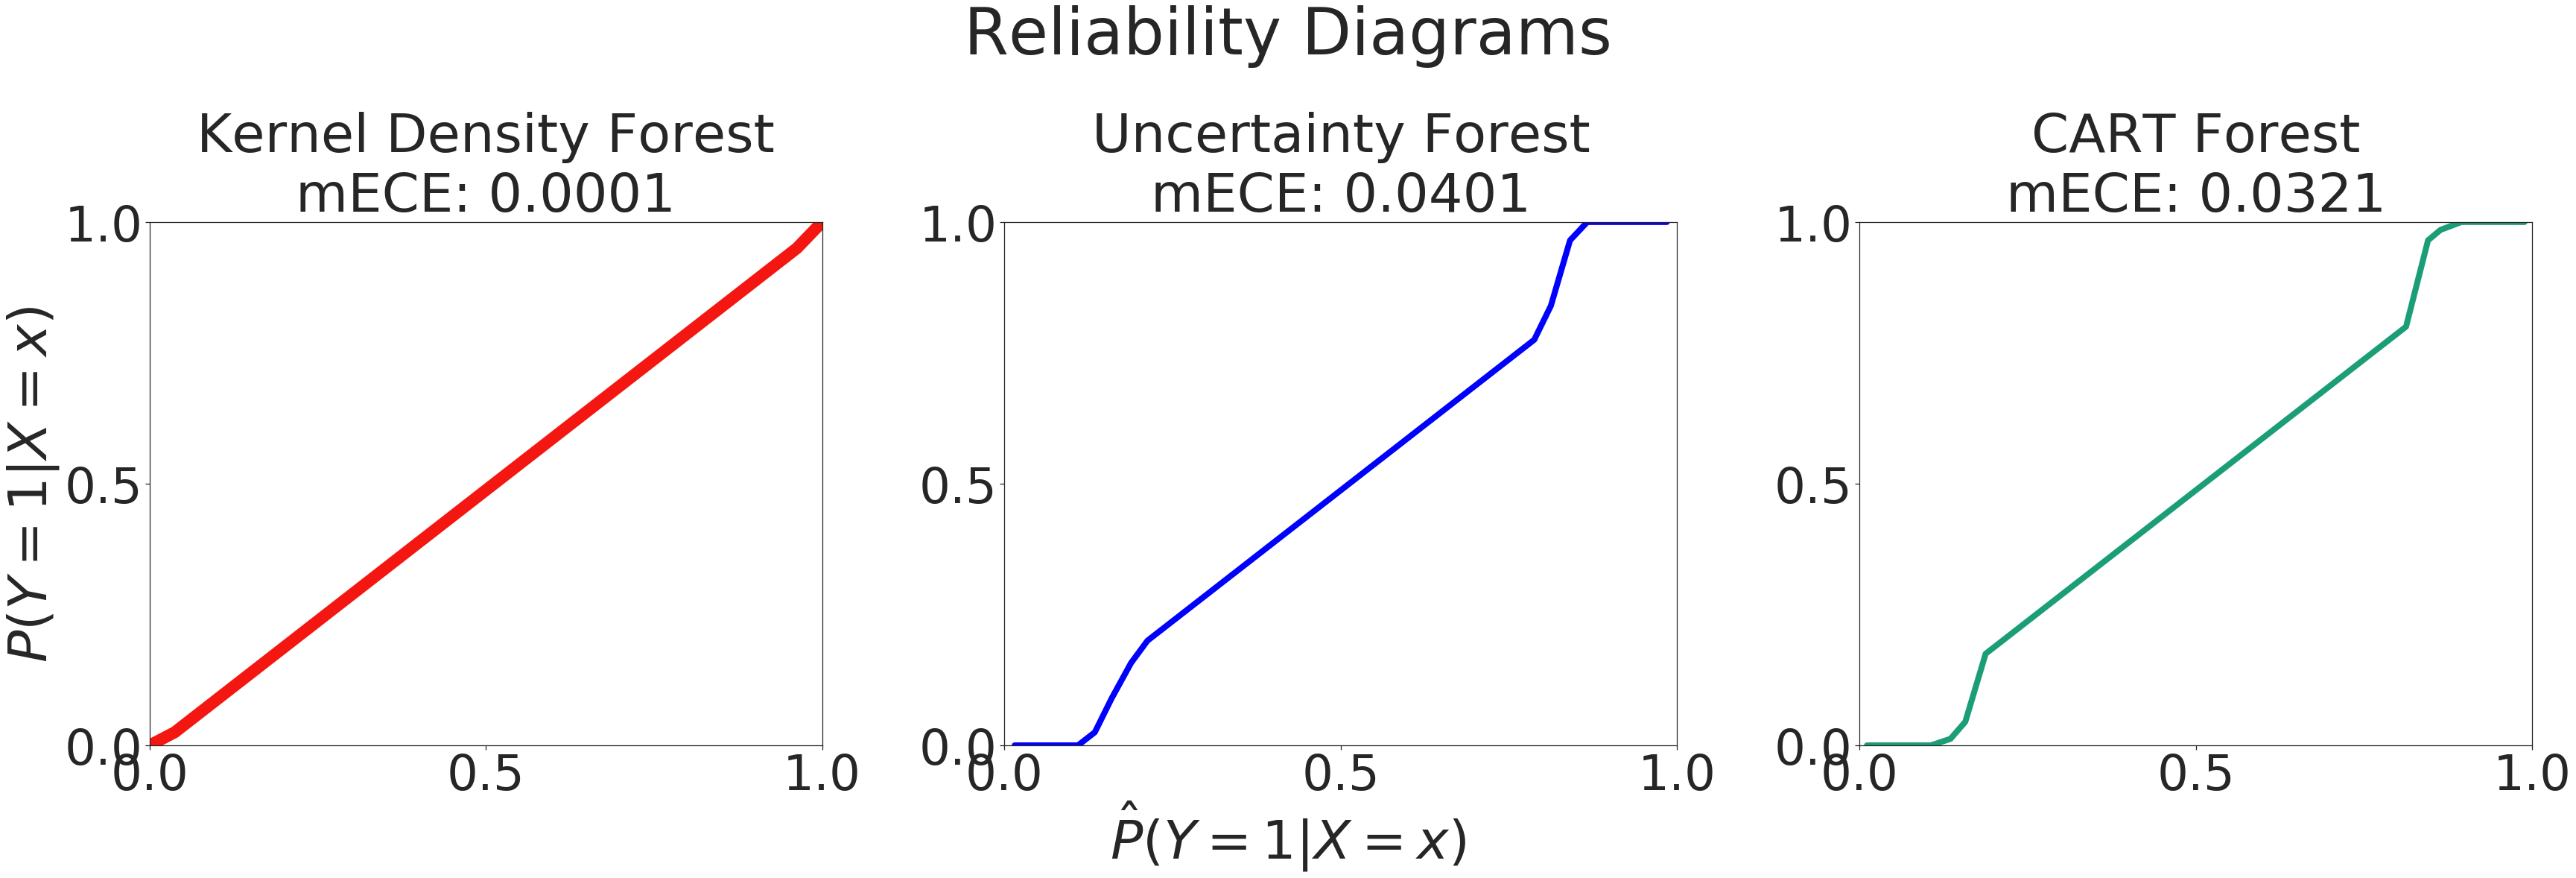

In [160]:
plot_fig1(algos)